# Nadaraya-Watson核回归

## 生成数据集

给定成对的数据集$\{ (x_1,y_1),\dots,(x_n,y_n)\}$，如何学习$f$来预测任意新输入x的输出$\hat y =f(x)$:
$$y_i =2 sin(x_i) + x_i^{0.8} + \epsilon$$

In [2]:
import torch as t
import torch.nn as nn
n_train=50
# 只要value不要下标
x_train,_=t.sort(t.rand(n_train)*5)

def f(x):
    return 2*t.sin(x)+x**0.8

y_train=f(x_train)+t.normal(0.,0.5,(n_train,))
x_test=t.arange(0,5,0.1)
y_truth=f(x_test)
n_test=len(x_test)
n_test

50

In [3]:
import sys
sys.path.append("../")
from pltutils import *

def plot_kernel_reg(y_hat):
    plot(x_test,[y_truth,y_hat],"x","y",legend=["Truth","Pred"],xlim=[0,5],ylim=[-1,5])
    plt.plot(x_train,y_train,"o",alpha=0.5)

# 平均汇聚
首先使用最简单的估计器来解决回归问题：基于平均汇聚来计算所有训练样本输出值的平均值：
$${f}(x) = \frac {1}{n} \sum_{i=1}^{n} y_i$$


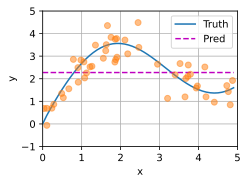

In [4]:
y_hat = t.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

# 非参数注意力汇聚
平均汇聚忽略了输入$x_i$所以需要根据输入的位置对输出$y_i$进行加权：
$$f(x) = \sum_{i=1}^n \frac {\mathbf{K}(x-x_i)} {\sum_{j=1}^n \mathbf{K}(x-x_j)} y_i$$

我们可以将$\frac {\mathbf{K}(x-x_i)} {\sum_{j=1}^n \mathbf{K}(x-x_j)}$看做是权重，就是对这些玩意的加权和，其中$mathbf{K}$是核（kernel），将权重换成别的东西也可以，所以我们有更通用的公式:
$$f(x) = \frac {1}{n} \sum_{i=1}^n \alpha(x,x_i)y_i$$

用注意力机制来理解的话，x是查询，$x_i,y_i$是键值对。

为了更好地去理解注意力机制，我们使用高斯核(Gaussian Kernel)：
$$\mathbf{K}(u) = \frac {1}{\sqrt {2\pi}} \exp (- \frac {u^2}{2})$$

将高斯核代入第一个公式中得到：
$$
\begin{split}\begin{aligned}
    f(x) &= \sum_{i=1}^n \alpha(x,x_i)y_i\\
        &= \sum_{i=1}^n \frac{\exp\left(- \frac{1}{2}{(x-x_i)}^2 \right)} {\sum_{j=1}^n \exp\left(- \frac{1}{2}{(x-x_j)}^2 \right)} y_i\\
        &= \sum_{i=1}^n softmax\left(- \frac{1}{2}{(x-x_i)}^2 \right)y_i

\end{aligned}\end{split}
$$

可以看到，所有的注意力权重加起来为1，如果一个键$x_i$越是接近给定的查询$x$，那么分配给这个键的对应值$y_i$的注意力权重就会越来越大，也就“获得了更多的注意力”。

而且Nadaraya-Watson核回归是一个非参数模型，我们将基于这个非参的汇聚模型来预测汇聚结果：


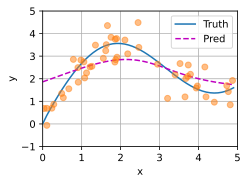

In [5]:
# X_repeat.shape = n_test,n_train
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train里面包含着键
# attention_weights.shape = n_test,n_train
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
# n_test,n_train MATMUL n_train,1 = n_test,1
y_hat = t.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)

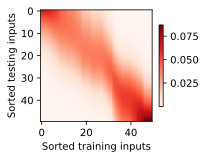

In [6]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),xlabel="Sorted training inputs",ylabel="Sorted testing inputs")

# 带参数的注意力汇聚
我们可以将可学习的参数$ \omega $集成到注意力汇聚中。

$$
\begin{split}\begin{aligned}
    f(x) &= \sum_{i=1}^n \alpha(x,x_i)y_i\\
        &= \sum_{i=1}^n \frac{\exp\left(- \frac{1}{2}{(x-x_i)\omega}^2 \right)} {\sum_{j=1}^n \exp\left(- \frac{1}{2}{(x-x_j)\omega}^2 \right)} y_i\\
        &= \sum_{i=1}^n softmax\left(- \frac{1}{2}{(x-x_i)\omega}^2 \right)y_i

\end{aligned}\end{split}
$$

## 小批量的矩阵乘法
为了有效地去计算小批量数据的注意力，可以利用深度学习框架中提供的批量矩阵乘法

假设第一个小批量数据包含$n$个矩阵：$\mathbf{x}_1,\dots,\mathbf{x}_n$,形状为$a \times b $，第二个小批量包含$n$个矩阵$\mathbf{y}_1,\dots,mathbf{y}_n$形状为$b \times c$ ，他们批量乘法得到了n个矩阵$ \mathbf{x}_1 \mathbf{y}_1,\dots, \mathbf{x}_n \mathbf{y}_n$,形状为$a \times c$,因此，他们的输出形状为 （n，a，c）

In [7]:
# 小批量的矩阵乘法
X=t.ones((2,1,4))
Y=t.ones((2,4,6))
#the shape should be 2,1,6
t.bmm(X,Y).shape

torch.Size([2, 1, 6])

In [11]:
# 可以使用小批量矩阵乘法来计算小批量数据中的加权平均值
weights =(t.ones((2,10))*.1).unsqueeze(1)
values =t.arange(20.0).reshape((2,10)).unsqueeze(-1)
t.bmm(weights,values)

tensor([[[ 4.5000]],

        [[14.5000]]])

In [13]:
# 定义带参数的Nadaraya-Watson核回归模型
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w=nn.Parameter(t.rand((1,),requires_grad=True))
    
    def forward(self,queries:t.Tensor,keys:t.Tensor,values:t.Tensor):
        queries=queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries-keys)*self.w)**2/2,dim=1)

        return t.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)

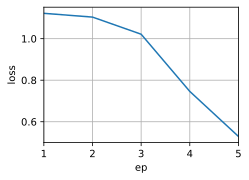

In [14]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)
                ].reshape((n_train, -1))

net = NWKernelRegression()
loss= nn.MSELoss()
trainer = t.optim.SGD(net.parameters(),lr=0.5)
animator = Animator(xlabel="ep",ylabel="loss",xlim=[1,5])

for ep in range(5):
    trainer.zero_grad()
    l = loss.forward(net.forward(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {ep + 1}, loss {float(l.sum()):.6f}')
    animator.add(ep + 1, float(l.sum()))


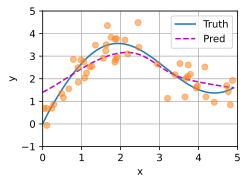

In [15]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)


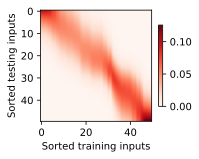

In [16]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')
